## Goal of this notebook

in wmt_budget_spellout we verified that the advective volume transport within the barents sea was the same as the transport through the gates.

we should also look at whether this works when we take the whole barents sea domain

In [1]:
# auto-reload edited modules
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, "/home/mmurakami/crios_backups/an_helper_functions")

# run the script into the curre nt kernel (vars/functions become available)
%run -i "/home/mmurakami/crios_backups/an_helper_functions/prep_grid_aste_90.py"

(450, 90)
RAC2d (40500,)
(100,)


In [2]:
dirroot = "/scratch3/atnguyen/aste_90x150x60/"
dirgrid = dirroot + "GRID_real8/"
dirgridnb = dirroot + "GRID_noblank/"
runstr= "run_c68v_heffmosm3x_layers_lessmem1_viscAHp5em2_it0000_pk0000000001/"
layers_path = dirroot + runstr
extL = "LAYERS"
dirmask = dirroot + "run_template/input_maskTransport/"
dirbudg = layers_path + "diags/BUDG/"
dirdiags = dirbudg
dirstate = layers_path + "diags/STATE/"
dirlayers = layers_path + "diags/LAYERS/"
dirtrsp = layers_path + "diags/TRSP/"

In [3]:
# try to use rdmds
fileprefix = "/scratch3/atnguyen/aste_90x150x60/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v2_mskBasin.bin"
ind = np.fromfile(filename, dtype=np.int32)  # auto-reads .meta for shape/dtype/order
orig_shape = (ind.shape)

ind2d = ind.reshape(ny,nx)

mymsk = np.full((ny,nx),np.nan)
mymsk[ind2d == 57408.0] = 1

# make this smaller
mymsk[:,27:50] = np.nan
mymsk[:160,12:30] = np.nan
mymsk[160:163,15:30] = np.nan

ind = ind.reshape(ny,nx)
mymsk = np.full((ny,nx),np.nan)
mymsk[ind == 57408.0] = 1

# make this smaller
mymsk[:,27:50] = np.nan
mymsk[:160,12:30] = np.nan
mymsk[160:163,15:30] = np.nan

In [4]:
landmsk = np.zeros((ny,nx))
landmsk[hf1 == 0] = 1
landmsk[hf1 == 1] = np.nan

In [5]:
# define the gates for the miniaste

# these are the indices we want to read from, but not write to
# at y = 186, we want -ADVy
x_bsoh = np.array([54, 54, 54, 54, 54])
x_bsov = np.array([0,  1,  2,  3,  4,  5,  6,  7,  8,  9])    # from Norway to Sp
y_bsoh = np.array([145, 146, 147, 148, 149])
y_bsov = np.array([186, 186, 186, 186, 186, 186, 186, 186, 186, 186])    # from Norway to Sp

x_spfjh = np.array([20,20,20,23,24,24,26,26])    # vertical gates from Sp to Fj as -x
y_spfjh = np.array([185,184,183,182,181,180,179,178])
x_spfjv = np.array([20,21,22,23,24,25,26])          # horizontal gates where we want to read -y
y_spfjv = np.array([183,183,183,183,182,180,180])

y_fjnzv = np.arange(165,175,1)
x_fjnzv = np.full_like(y_fjnzv,27)    # horizontal gate where we want to read -x

y_nzruv = np.arange(152,155,1)
x_nzruv = np.full_like(y_nzruv,12)   # horizontal gate where we want to read -x

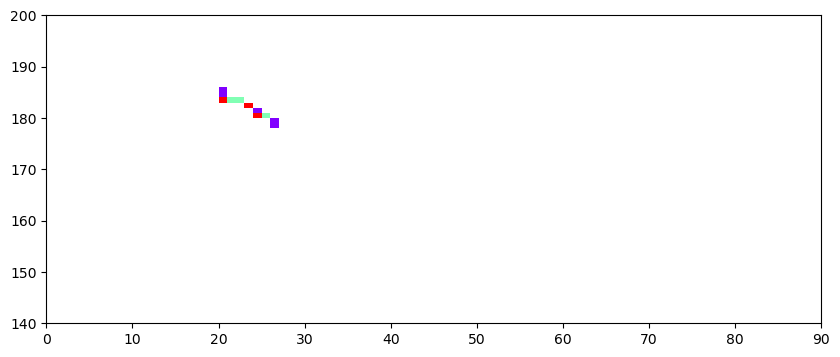

In [24]:
testmsk = gates_mask.copy()
testmsk[:,:19] = np.nan
testmsk[:,30:] = np.nan
testmsk[:178,:] = np.nan

plt.pcolormesh(testmsk,cmap='rainbow')
# plt.pcolormesh(get_aste_tracer(testmsk,nfx,nfy)[0],cmap='rainbow')
# plt.xlim(140,180)
plt.ylim(140,200)
y_spfjv2,x_spfjv2 = np.where(testmsk == 2)[0],np.where(testmsk == 2)[1]
y_spfjh2,x_spfjh2 = np.where(testmsk == 1)[0],np.where(testmsk == 1)[1]
y_spfjb2,x_spfjb2 = np.where(testmsk == 3)[0],np.where(testmsk == 3)[1]

In [25]:
# gates_mask starts as NaN everywhere
gates_mask = np.full((ny, nx), np.nan, dtype=float)

def _mark_points(mask, xs, ys, code, ny, nx, name="gate"):
    """
    Mark (y, x) points in mask with 'code'.
    If a point already has a different non-NaN code, set it to 3 (overlap).
    Bounds are clipped to the grid silently.
    """
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    if xs.shape != ys.shape:
        raise ValueError(f"{name}: x/y length mismatch: {xs.shape} vs {ys.shape}")

    # clip to valid indices just in case
    xi = np.clip(xs.astype(int), 0, nx-1)
    yi = np.clip(ys.astype(int), 0, ny-1)

    for j, i in zip(yi, xi):
        cur = mask[j, i]
        if np.isnan(cur):
            mask[j, i] = code
        elif cur == code or cur == 3:
            # already same code or already overlap — leave as is
            continue
        else:
            mask[j, i] = 3  # overlap with different code
    return mask

# ---- mark H gates with code = 1 ----
gates_mask = _mark_points(gates_mask, x_bsoh, y_bsoh, 1, ny, nx, name="bsoh")
gates_mask = _mark_points(gates_mask, x_spfjh, y_spfjh, 1, ny, nx, name="spfjh")

# ---- mark V gates with code = 2 ----
gates_mask = _mark_points(gates_mask, x_bsov,  y_bsov,  2, ny, nx, name="bsov")
gates_mask = _mark_points(gates_mask, x_spfjv, y_spfjv, 2, ny, nx, name="spfjv")
gates_mask = _mark_points(gates_mask, x_fjnzv, y_fjnzv, 1, ny, nx, name="fjnzv")
gates_mask = _mark_points(gates_mask, x_nzruv, y_nzruv, 1, ny, nx, name="nzruv")

# Optional: if you prefer 0 instead of NaN for “not a gate”
# gates_mask = np.nan_to_num(gates_mask, nan=0.0)

In [26]:
# let's make a mask of these to double check that we did this correctly

gates_mask[182,23] = 3
gates_mask[180,24] = 3 
gates_mask[180,26] = np.nan
gates_mask[182,24] = np.nan
gates_mask[183,23] = np.nan

In [27]:
# bbb.boundsT=squeeze(rdmds([dirrun 'layers2TH']))'; bbb.nT=length(bbb.boundsT)-1;
# bbb.boundsS=squeeze(rdmds([dirrun 'layers1SLT']))';bbb.nS=length(bbb.boundsS)-1;
# bbb.binwidthT=(bbb.boundsT(2:end)-bbb.boundsT(1:end-1));
# bbb.binwidthS=(bbb.boundsS(2:end)-bbb.boundsS(1:end-1));

# bbb.binwidthT1=0.5.*(bbb.binwidthT(2:end)+bbb.binwidthT(1:end-1)); %same as diff(bbb.binmidT)
# bbb.binwidthS1=0.5.*(bbb.binwidthS(2:end)+bbb.binwidthS(1:end-1)); %same as diff(bbb.binmidS)
# bbb.binmidT=(bbb.boundsT(2:end)+bbb.boundsT(1:end-1))./2;
# bbb.binmidS=(bbb.boundsS(2:end)+bbb.boundsS(1:end-1))./2;
# nT=bbb.nT;nS=bbb.nS;nTm1=bbb.nT-1;nSm1=bbb.nS-1;

# try to replicate exactly the An way
boundsT = np.round(np.squeeze(rdmds(layers_path + "layers2TH")).ravel(),1)
nT = boundsT.size - 1
boundsS = np.round(np.squeeze(rdmds(layers_path + "layers1SLT")).ravel(),1)
nS = boundsS.size - 1

binwidthT = boundsT[1:] - boundsT[:-1]
binwidthS = boundsS[1:] - boundsS[:-1]

binwidthT1 = 0.5 * (binwidthT[1:] + binwidthT[:-1])
binwidthS1 = 0.5 * (binwidthS[1:] + binwidthS[:-1])

binmidT = (boundsT[1:] + boundsT[:-1]) /2
binmidS = (boundsS[1:] + boundsS[:-1]) /2

nT = nT
nS = nS
nTm1 = nT-1
nSm1 = nS-1

In [28]:
# we need to also create the theta and salt bins for this area
tsstr = np.array(["0000000002","0000000003"])
t2 = int(tsstr[1]) # for the offline version

In [29]:
ffac=1e-6
G_T=np.array([])
metaT=parsemeta(layers_path + "diags/LAYERS/layers_3d_Ttend." + tsstr[1] + ".meta")
nFldsT = metaT["fldList"]
print(len(nFldsT))
setTtend=nFldsT.copy()
fldsIwant = np.array(['LaTh2TH','LaTz2TH'])

# check for the correct diagnostics
metaT['fldList']   # 13, 14, 15, 16, 19, 22
b = metaT['fldList']
ifldT = np.array([1,2])    # surf, hDiff, vDiff, hADV, vADV, total tend
# print(np.array(b)[ifldT])  # for G_T

# remake the following to look for the existing terms and see if we can recreate
# ['LaTs2TH' 'LaTh2TH' 'LaTz2TH' 'LTha2TH' 'LTza2TH' 'LTto2TH']
ifldT = np.array([0,1,2,7,8,11])
print(np.array(b)[ifldT])  # for G_T


# we will just do the exact same thing for all the terms
metaS=parsemeta(layers_path + "diags/LAYERS/layers_3d_Stend." + "0000000003" + ".meta")
nFldsS = metaS["fldList"]
print(len(nFldsT))
setStend=nFldsS.copy()

# check for the correct diagnostics
metaS['fldList']   # 13, 14, 15, 16, 19, 22
b = metaS['fldList']
# ['LaSs1SLT' 'LaSh1SLT' 'LaSz1SLT' 'LSha1SLT' 'LSza1SLT' 'LSto1SLT']
ifldS = np.array([12,13,14,19,20,23])

# print(b[12,13,14,19,20,23])
print(np.array(b)[ifldS])  # for G_S

24
['LaTs2TH' 'LaTh2TH' 'LaTz2TH' 'LTha2TH' 'LTza2TH' 'LTto2TH']
24
['LaSs1SLT' 'LaSh1SLT' 'LaSz1SLT' 'LSha1SLT' 'LSza1SLT' 'LSto1SLT']


In [30]:
# mymsk3d.shape
mymsk_1d = mymsk.reshape(orig_shape, order='C')
mymsk_1dtile = np.tile(mymsk_1d[np.newaxis,:],(nT-1,1))
hf2dtile.shape
# hf2dtile.shape
iwet_mine = np.where(~np.isnan(mymsk_1d))
iwet_mine[0].shape
iwet_mine = iwet_mine[0]   # this is already the 1D array of wetpoints to use, we can add these below by indexing

In [31]:
# make the G_T term
# we did not mask this or the other one which is why they are the same
# try to make sure we maskt this here.

name = "BarentsS"
G_T = {}
G_T[name] = {}
ts = tsstr[1]
    
# now loop through
G_T[name][ts] = {}
for i in range(len(ifldT)-1, -1, -1):
    tmp = read_float64_skip(layers_path + "diags/LAYERS/layers_3d_Ttend." + tsstr[-1] + ".data", nx*ny*(nT-1),ifldT[i])
    tmp = np.reshape(tmp,(nT-1,nx*ny))
    tmp = tmp * (rac2dtile * hf2dtile) #* ffac

    if i == ifldT.shape[0]-1:
        # if LTto2TH, do not remove from residual
        residT = tmp
    else:
        # else if vADV, hADV, vDiff, hDiff, surface, remove from residual
        residT = residT-tmp
    
    # just do the Barents Sea for this one
    a = np.nansum(tmp[:,iwet_mine],axis=1)
    G_T[name][ts][setTtend[ifldT[i]]] = a

# residT was wrong here so we can just ignore

In [32]:
t2 = int(tsstr[1])
# 'diags/state_3d_set1'
# read theta and salt averages from the t2 timestep (average)
file_name = "state_3d_set1"
meta_state_3d_set1 = parsemeta(dirstate + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_state_3d_set1["fldList"])
varnames = np.array(["THETA","SALT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
THETA,its,meta = rdmds(os.path.join(dirstate, file_name),t2,returnmeta=True,rec=recs[0])
SALT,its,meta = rdmds(os.path.join(dirstate, file_name),t2,returnmeta=True,rec=recs[1])

THETA = THETA.reshape(nz,ny,nx)
SALT = SALT.reshape(nz,ny,nx)

In [33]:
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_TH","ADVy_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])

# now 3d zfluxes
file_name = "budg3d_zflux_set1"
meta_budg3d_zflux_set1 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set1["fldList"])
varnames = np.array(["ADVr_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVr_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
ADVr_TH = ADVr_TH.reshape(nz,ny,nx)

hf = mygrid['hFacC']

ADV_hconv = calc_UV_conv_mod(nfx, nfy,get_aste_faces(ADVx_TH.reshape(nz, ny, nx), nfx, nfy),get_aste_faces(ADVy_TH.reshape(nz, ny, nx), nfx, nfy))
ADV_hconv = ADV_hconv * hf   # degC·m^3/s at cell centers (matches: ff.DFh = ff.DFh .* hf)
ADVhT = ADV_hconv

trWtopADV = -(ADVr_TH)

ADVrT = np.zeros((nz,ny,nx),dtype=float)
ADVrT[:-1,:,:] = (trWtopADV[:-1] - trWtopADV[1:])  # this is not the way we did it in the original code but this is the way An has done it so we try

In [34]:
mymsk3d = np.tile(mymsk[np.newaxis,:,:],(nz,1,1))

In [35]:
# define the ADVh total for this mymsk2
G_T_offline_new = np.zeros((2, nT-1))
dF_Tnew = np.zeros((2, nT-1))
Lijnew = np.zeros((2, nT-1), dtype=int)

# also mask these by mymsk3
# flatten the 3D arrays along all dimensions, as MATLAB’s tmp(:) does
T_flat    = np.ravel(THETA*hf* mymsk3d, order='F')
ADVh_flat = np.ravel(ADVhT*hf* mymsk3d,  order='F')
ADVr_flat = np.ravel(ADVrT*hf* mymsk3d,  order='F')

for i in range(nT-1):
    # MATLAB: ij = find(tmp(:) >= bbb.binmidT(i) & tmp(:) < bbb.binmidT(i+1))
    ij = np.where((T_flat >= binmidT[i]) & (T_flat < binmidT[i + 1]))[0]
    Lijnew[0, i] = len(ij)

    if len(ij) > 0:
        # MATLAB: dF_Tnew(4,i)=sum(ff.advh(ij)); dF_Tnew(5,i)=sum(ff.advr(ij));
        dF_Tnew[0, i] = np.nansum(ADVh_flat[ij])
        dF_Tnew[1, i] = np.nansum(ADVr_flat[ij])

# MATLAB: G_T_offline_new = dF_Tnew ./ repmat(bbb.binwidthT1,[6 1])
G_T_offline_new = dF_Tnew / binwidthT1[None, :]

Text(0, 0.5, 'm^3/s')

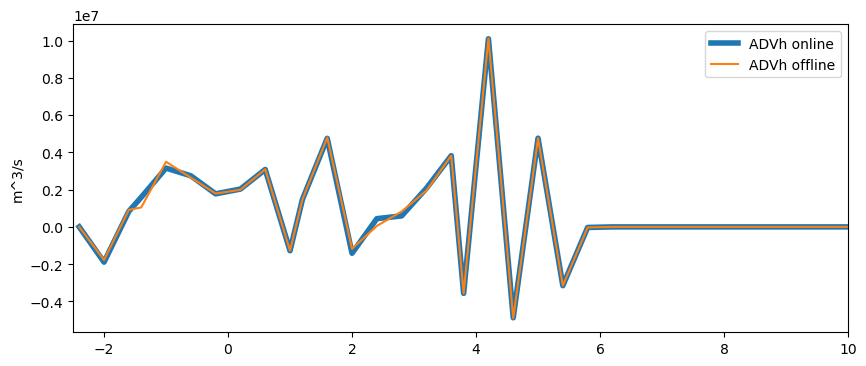

In [36]:
# THIS CODE WE WANT TO COPY LATER TO USE FOR THE SALT BUDGET
fig = plt.figure()

ax = plt.subplot(111)
ax.set_xlim(-2.5,10)

ax.plot(boundsT.flatten()[1:-1],G_T['BarentsS'][ts]['LTha2TH'],linewidth=4,label='ADVh online')
ax.plot(boundsT.flatten()[1:-1],G_T_offline_new[0],label='ADVh offline')
ax.legend()
ax.set_ylabel("m^3/s")

In [37]:
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_TH","ADVy_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])

ADVx_TH = ADVx_TH.reshape(nz,ny,nx)
ADVy_TH = ADVy_TH.reshape(nz,ny,nx)

In [38]:

# --- reshape to 3D ---
ADVx_TH = ADVx_TH.reshape((nz, ny, nx))   # advective heat flux on x-faces
ADVy_TH = ADVy_TH.reshape((nz, ny, nx))   # advective heat flux on y-faces
THETA   = THETA.reshape((nz, ny, nx))     # cell-centered temperature

# ------------------------------------------------------------------
# 1. Build theta at faces
# ------------------------------------------------------------------

# x-faces: between (i-1, i) along x
theta_x = np.zeros_like(ADVx_TH)
theta_x[:, :, 1:] = 0.5 * (THETA[:, :, 1:] + THETA[:, :, :-1])
theta_x[:, :, 0]  = theta_x[:, :, 1]      # simple fill for western boundary

# y-faces: between (j-1, j) along y
theta_y = np.zeros_like(ADVy_TH)
theta_y[:, 1:, :] = 0.5 * (THETA[:, 1:, :] + THETA[:, :-1, :])
theta_y[:, 0, :]  = theta_y[:, 1, :]      # simple fill for southern boundary

# ------------------------------------------------------------------
# 2. Convert heat flux (degC·m^3/s) -> volume flux (m^3/s)
#    q_vol = q_heat / theta_face
# ------------------------------------------------------------------

eps = 1e-6  # to avoid divide-by-zero in very cold cells

ADVx_vol = np.zeros_like(ADVx_TH)
mask_x   = np.isfinite(theta_x) & (np.abs(theta_x) > eps)
ADVx_vol[mask_x] = ADVx_TH[mask_x] #/ theta_x[mask_x]

ADVy_vol = np.zeros_like(ADVy_TH)
mask_y   = np.isfinite(theta_y) & (np.abs(theta_y) > eps)
ADVy_vol[mask_y] = ADVy_TH[mask_y] #/ theta_y[mask_y]

# bolus
ADVx_vol = np.zeros_like(ADVx_TH)
mask_x   = np.isfinite(theta_x) & (np.abs(theta_x) > eps)
ADVx_vol[mask_x] = (ADVx_TH[mask_x]) #/ theta_x[mask_x]

ADVy_vol = np.zeros_like(ADVy_TH)
mask_y   = np.isfinite(theta_y) & (np.abs(theta_y) > eps)
ADVy_vol[mask_y] = (ADVy_TH[mask_y]) #/ theta_y[mask_y]

# ------------------------------------------------------------------
# 3. Build gateway transports using volume fluxes at the faces
#    Sign convention: comments assume "positive into basin"
# ------------------------------------------------------------------

# ADVx_vol = ADVx_TH
# ADVy_vol = ADVy_TH

# ---- BSO ----
ADV_west = np.zeros((nz, ny, nx))
y_bso_all = np.array([], dtype=int)
x_bso_all = np.array([], dtype=int)

# horizontal faces (u-faces)
for j, i in zip(y_bsoh, x_bsoh):
    # flux through x-face at (j,i) mapped into cell (j,i)
    ADV_west[:, j, i] += ADVx_vol[:, j, i]    # + into basin
    y_bso_all = np.append(y_bso_all, j)
    x_bso_all = np.append(x_bso_all, i)

# vertical faces (v-faces)
for j, i in zip(y_bsov, x_bsov):
    # flux through y-face at (j,i) mapped into cell (j-1,i)
    ADV_west[:, j-1, i] -= ADVy_vol[:, j, i]  # sign chosen so + into basin
    y_bso_all = np.append(y_bso_all, j-1)
    x_bso_all = np.append(x_bso_all, i)

# ---- FJNZ ----
ADV_FJNZ = np.zeros((nz, ny, nx))
y_fjnz_all = np.array([], dtype=int)
x_fjnz_all = np.array([], dtype=int)

for j, i in zip(y_fjnzv, x_fjnzv):
    # x-face at (j,i) mapped into (j, i-1), + into basin
    ADV_FJNZ[:, j, i-1] -= ADVx_vol[:, j, i]
    y_fjnz_all = np.append(y_fjnz_all, j)
    x_fjnz_all = np.append(x_fjnz_all, i-1)

# ---- SPFJ (NZ exit) ----
ADV_SPFJ = np.zeros((nz, ny, nx))
y_spfj_all = np.array([], dtype=int)
x_spfj_all = np.array([], dtype=int)

# ORIGINAL
# for j, i in zip(y_spfjh, x_spfjh):
#     ADV_SPFJ[:, j, i-1] -= ADVx_vol[:, j, i]   # + into basin
#     y_spfj_all = np.append(y_spfj_all, j)
#     x_spfj_all = np.append(x_spfj_all, i-1)

# # y-faces
# for j, i in zip(y_spfjv, x_spfjv):
#     ADV_SPFJ[:, j-1, i] -= ADVy_vol[:, j, i]   # + into basin
#     y_spfj_all = np.append(y_spfj_all, j-1)
#     x_spfj_all = np.append(x_spfj_all, i)

# # CHANGED
for j,i in zip(y_spfjv2,x_spfjv2):
    ADV_SPFJ[:, j-1, i] -= ADVy_vol[:, j, i]
    y_spfj_all = np.append(y_spfj_all, j-1)
    x_spfj_all = np.append(x_spfj_all, i)

for j,i in zip(y_spfjh2,x_spfjh2):
    ADV_SPFJ[:, j, i-1] -= ADVx_vol[:, j, i]
    y_spfj_all = np.append(y_spfj_all, j)
    x_spfj_all = np.append(x_spfj_all, i-1)
    
for j,i in zip(y_spfjb2,x_spfjb2):
    ADV_SPFJ[:, j, i-1] -= ADVx_vol[:, j, i]
    y_spfj_all = np.append(y_spfj_all, j)
    x_spfj_all = np.append(x_spfj_all, i-1)
    ADV_SPFJ[:, j-1, i] -= ADVy_vol[:, j, i]
    y_spfj_all = np.append(y_spfj_all, j-1)
    x_spfj_all = np.append(x_spfj_all, i)

# ---- NZRU (small Russia gate) ----
ADV_NZRU = np.zeros((nz, ny, nx))
y_nzru_all = np.array([], dtype=int)
x_nzru_all = np.array([], dtype=int)

for j, i in zip(y_nzruv, x_nzruv):
    ADV_NZRU[:, j, i-1] -= ADVx_vol[:, j, i]   # + into basin
    y_nzru_all = np.append(y_nzru_all, j)
    x_nzru_all = np.append(x_nzru_all, i-1)


In [40]:
def _bincount_sum_with_nan(idx, vals, nout):
    """
    NaN-aware per-bin sum:
    if *all* entries in a bin are NaN, that bin returns NaN;
    otherwise NaNs are ignored and finite values are summed.
    """
    # track counts of non-nan contributions
    finite = np.isfinite(vals)
    sums   = np.bincount(idx[finite], vals[finite], minlength=nout).astype(float)
    counts = np.bincount(idx[finite], None, minlength=nout).astype(float)
    out = sums
    out[counts == 0] = np.nan
    return out

In [42]:
# binmidT[i] <= THETA < binmidT[i+1], i=0..nT-2
theta_flat = THETA.ravel()
bin_idx_mid = np.digitize(theta_flat, binmidT, right=False) - 1
valid_mid   = (bin_idx_mid >= 0) & (bin_idx_mid < nTm1) & np.isfinite(theta_flat)
idx_mid     = bin_idx_mid[valid_mid]

In [43]:
ADV_west_flat   = ADV_west.ravel()
ADV_fjnz_flat   = ADV_FJNZ.ravel()
ADV_spfj_flat   = ADV_SPFJ.ravel()
ADV_nzru_flat   = ADV_NZRU.ravel()


# per-bin sums with NaN-propagation
ADVh_BSO = _bincount_sum_with_nan(idx_mid, ADV_west_flat[valid_mid], nTm1)
ADVh_FJNZ = _bincount_sum_with_nan(idx_mid, ADV_fjnz_flat[valid_mid], nTm1)
ADVh_SPFJ = _bincount_sum_with_nan(idx_mid, ADV_spfj_flat[valid_mid], nTm1)
ADVh_NZRU = _bincount_sum_with_nan(idx_mid, ADV_nzru_flat[valid_mid], nTm1)


# edge-based G (m^3/s): divide by edge binwidths
# this is not correct because we want to divide by Face T
G_BSO = ADVh_BSO #/ binwidthT1
G_FJNZ = ADVh_FJNZ #/ binwidthT1
G_SPFJ = ADVh_SPFJ #/ binwidthT1
G_NZRU = ADVh_NZRU #/ binwidthT1

In [50]:
print(np.nansum(G_BSO) + np.nansum(G_FJNZ) + np.nansum(G_SPFJ) + np.nansum(G_NZRU))

10512990.032651437


In [51]:
print(np.nansum(ADVhT * mymsk3d))

10512990.032651436


In [52]:
# these are the same in units of degC.m^3/s!! almost success. let's check in m^3/s

In [56]:
np.nansum(dF_Tnew) / np.nansum(binwidthT1)

251206.45239310482

In [57]:
print((np.nansum(G_BSO) + np.nansum(G_FJNZ) + np.nansum(G_SPFJ) + np.nansum(G_NZRU))/np.nansum(binwidthT1))

251206.45239310488


In [ ]:
# same same!